# Table of contents 
- [Setup](#setup) 
    - [Purpose](#Purpose)
    - [Libraries](#libraries)
- [Text classification using word embeddings](#textclassificationusingwordembeddings)
    - [Fine-tuning SciBERT](#fine-tuningscibert)
        - [Prepping the data](#preppingthedata) 
        - [Using manually labeled data](#usingmanuallylabeleddata)
        - [Using Zhao et al.'s labeled data](#usingZhaoetalslabeleddata)
        - [Performance comparison](#performancecomparison)
- [Classify sentences and URLs](#classifysentencesandURLs) 
- [Material URLs](#materialURLs)
    - [Validate URLs](#validateURLs)
- [Investigation](#investigation)
    - [Material, method, and supplement URLs](#materialmethodandsupplementURLs)
    - [Valid and invalid material URLs](#validandinvalidmaterialURLs) 
- [References](#references) 

<a name='setup'></a>
# 0. Setup 

This notebook contains the code to extract the dataset-URLs used in the articles published in NeuroImage in 2022. 
<br>

<a name='purpose'></a> 
## 0.1. Purpose

This notebook is one of a few whose purpose is to locate and extract publicly available URLs linking to datasets used for analysis in the research articles published in NeuroImage in 2022. In this specific notebook, sentence classification is performed using a pre-trained word embedding model, Sci-BERT, which is fine-tuned using manually labeled data. 
<br>

<a name='libraries'></a>
## 0.2. Libraries 

In [1]:
import pandas as pd
import numpy as np
import json 
import os 
import re 
import io
import requests
import random

# Huggingface modules used for sentence - and thus URL - classifications (Wolf et al. 2020)
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EvalPrediction
from datasets import load_metric, Dataset, DatasetDict 
import evaluate
import torch

# Scikit-learn (Pedregosa et al. 2011)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

# Validate URLs 
from urllib.request import urlopen
from urllib import request, error

# Matplotlib for visualisations (Hunter 2007)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

2023-11-23 09:26:40.366029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='textclassificationusingwordembeddings'></a>
# 1. Text classification using word embeddings

As my overarching goal is to identify and extract the datasets, I can classify the sentences that contain a URL based on the assumption that the sentences will somehow reflect what the URL contains. 

Inspired by the work of Halford (2020), I perform text classification using word embeddings (Birunda & Devi (2021), Kosar et al. (2022), Haj-Yahia et al. (2019)), but I use the pre-trained SciBERT model (Beltagy et al. 2019) and finetune it using manually labeled data, comparing two different sets of labeled data. 

<a name='scibert'></a>
## 1.1. Fine-tuning SciBERT 

SciBERT (Beltagy et al. 2019) is a BERT model (Devlin et al. 2019) that is trained on scientific papers from semanticscholar.org. They use the full text of the papers in training. I use Huggingface's Transformers (Wolf et al. 2020) and datasets (Lhoest et al. 2021) to download and finetune SciBert and classify my sentences. 

Together with two annotators, we manually labeled 129 sentences (see Resources/LabelingGuide.pdf for the labels and their definitions) that were used to fine-tune SciBERT. I use a function from scikit-learn (Pedregosa et al. 2011) to split the data into training and test sets. 

Cao et al. (2023) similarly fine-tune SciBERT to identify material, method, and supplement URLs in their dataset. They use an annotated dataset presented by Zhao et al. (2019) to do the fine-tuning. 

To compare the performance of SciBERT trained on my labeled data and one trained on the labeled data by Zhao et al. (2019), I convert and conform my labels to those presented by Zhao et al. (2019) in the following manner: 

| **My labels**                                            | **Zhao et al. (2019) labels** |
|------------------------------------------------------|---------------------------|
| Dataset <br> Preprocessed dataset                       | Material                  |
| Analysis <br> Atlas/map <br> Model <br> Software, incl. plugins, toolbox, packages, and functions | Method                    |
| Person or institution <br> Resource | Supplement                |

In this setup, I remove the labels **Not a URL** and **Not enough information**, since those labels are neither Material, Method, nor Supplement. 

Upon fine-tuning the two SciBERTs, I can compare their performance and pick the best-performing model to classify the rest of the sentences I extracted from the NeuroImage articles. 

I wrote the following code using two guides and one code repository in particular: 
- caohanch. (n.d.). Paper_data_method_sharing/link_classification.ipynb at main · caohanch/paper_data_method_sharing [Jupyter Notebook]. Retrieved November 15, 2023, from https://github.com/caohanch/paper_data_method_sharing/blob/main/link_classification.ipynb
- 🤗 Hugging Face. (n.d.). Fine-tuning BERT (and friends) for multi-label text classification [Jupyter Notebook]. Retrieved November 9, 2023, from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o
- Text classification. (n.d.). 🤗 HuggingFace - Transformers. Retrieved October 29, 2023, from https://huggingface.co/docs/transformers/tasks/sequence_classification

I also read and found the following useful: 
- Choudhary, R. (2021, December 29). Fine-Tuning Bert for Tweets Classification ft. Hugging Face. MLearning.Ai. https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf

In [2]:
directory_path = '../Data/QA_manually_labeled_data'
file_path = os.path.join(directory_path, 'labeled_data.csv')
labeled_data = pd.read_csv(file_path)

In [3]:
labeled_data = labeled_data.rename(columns={"Original_sentence": "sentence", "True_label": "label"})

In [4]:
# Add an ID column (assuming 'labeled_data' is a DataFrame)
labeled_data['ID'] = labeled_data.index

<a name='preppingthedata'></a>
### 1.1.1. Prepping the data
I start by: 
- One-hot encoding the labels (following the guide from 🤗 Hugging Face. (n.d.) at this link: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o)
- Conforming the labels to those by Zhao et al. (2019)
- Splitting my labeled dataset into training, evaluation, and test
    - I will fine-tune a SciBERT using my training and evaluation data and another using the training and test data from Zhao et al. (2019)
    - I will use the test data to compare the performance of the two models 

In [5]:
# One-hot encode the labels based on the 'label_mapping'
label_mapping = {
    "Analysis": 'ana',
    "Atlas/map": 'at_map',
    "Dataset": 'data',
    "Model": 'mod',
    "Not a URL": 'no_url',
    "Not enough information": 'no_info',
    "Person or institution": 'pers_inst',
    "Processed dataset": 'pro_data',
    "Resource": 'res',
    "Software, incl. plugins, toolbox, packages, and functions": 'soft'
}

I need to one-hot encode the labels to ensure the model can read the multilabels. 

In [6]:
# One-hot encode the labels based on the 'label_mapping'
for label_name, label_code in label_mapping.items():
    labeled_data[label_name] = labeled_data['label'].apply(lambda x: int(label_code in x))

# Drop the original 'label' column if needed
labeled_data = labeled_data.drop(columns=['label'])

In [7]:
labeled_data

,sentence,ID,Analysis,Atlas/map,Dataset,Model,Not a URL,Not enough information,Person or institution,Processed dataset,Resource,"Software, incl. plugins, toolbox, packages, and functions"
0,"In addition, as introduced in Section 3.1.3.1 ...",0,0,0,0,0,1,0,0,0,0,0
1,"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",1,0,0,0,0,1,0,0,0,0,0
2,All electrode coordinates and labels were save...,2,0,0,0,0,0,0,0,0,1,0
3,"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",3,0,0,0,0,1,0,0,0,0,0
4,∗ Data used in preparation of this article wer...,4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
117,Funding JD was funded by the Rennes Clinical N...,117,0,0,0,0,0,0,1,0,0,0
118,We used MRIcroGL (www.mccauslandcenter.sc.edu/...,118,0,0,0,0,0,0,0,0,0,1
119,The 3D ﬁgure was realized using BrainNet viewe...,119,0,0,0,0,0,0,0,0,0,1
120,Seed-based d mapping The SDM-PSI (www.sdmproje...,120,0,0,0,0,0,0,0,0,0,1


In [8]:
# Dictionary for the new column names
new_column_names = {
    "Analysis": 'Method',
    "Atlas/map": 'Method',
    "Dataset": 'Material',
    "Model": 'Method',
    "Person or institution": 'Supplement',
    "Processed dataset": 'Material',
    "Resource": 'Supplement',
    "Software, incl. plugins, toolbox, packages, and functions": 'Method',
}

# Columns to exclude from the new dataframe
columns_to_exclude = ['Not a URL', 'Not enough information']

# New columns with the new names
for new_column in ['Method', 'Material', 'Supplement']:
    # Create the new column if it doesn't exist
    if new_column not in labeled_data.columns:
        labeled_data[new_column] = 0

# Map the original columns to the new columns
for original_column, new_column in new_column_names.items():
    labeled_data[new_column] = labeled_data[new_column] | labeled_data[original_column]

# Drop the original columns and columns to exclude
columns_to_drop = list(new_column_names.keys()) + columns_to_exclude
labeled_data = labeled_data.drop(columns=columns_to_drop)

In [9]:
labeled_data

,sentence,ID,Method,Material,Supplement
0,"In addition, as introduced in Section 3.1.3.1 ...",0,0,0,0
1,"Vries, I.E.J.de, Driel, J.van, Olivers, C.N.L....",1,0,0,0
2,All electrode coordinates and labels were save...,2,0,0,1
3,"Wen, J., Thibeau-Sutre, E., Diaz-Melo, M., Sam...",3,0,0,0
4,∗ Data used in preparation of this article wer...,4,0,1,0
...,...,...,...,...,...
117,Funding JD was funded by the Rennes Clinical N...,117,0,0,1
118,We used MRIcroGL (www.mccauslandcenter.sc.edu/...,118,1,0,0
119,The 3D ﬁgure was realized using BrainNet viewe...,119,1,0,0
120,Seed-based d mapping The SDM-PSI (www.sdmproje...,120,1,0,0


In [10]:
X = labeled_data[['ID', 'sentence']]
y = labeled_data[['Method', 'Material', 'Supplement']]

# Split data into training, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Reset the index before concatenation
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

# Create Datasets
train_dataset = Dataset.from_pandas(pd.concat([X_train, y_train], axis=1))
val_dataset = Dataset.from_pandas(pd.concat([X_val, y_val], axis=1))
test_dataset = Dataset.from_pandas(pd.concat([X_test, y_test], axis=1))

dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'sentence', 'Method', 'Material', 'Supplement'],
        num_rows: 97
    })
    validation: Dataset({
        features: ['ID', 'sentence', 'Method', 'Material', 'Supplement'],
        num_rows: 12
    })
    test: Dataset({
        features: ['ID', 'sentence', 'Method', 'Material', 'Supplement'],
        num_rows: 13
    })
})

<a name='usingmanuallylabeleddata'></a>
### 1.1.2. Using manually labeled data

In [12]:
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'sentence']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Method', 'Material', 'Supplement']

In [184]:
# Load SciBERT with uncased scivocab 
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [185]:
def preprocess_data(examples, tokenizer):
    """This function is a copy of the function with the same name from 🤗 Hugging Face. (n.d.) from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o
    The only change I made is adding the 'tokenizer' parameter. 
    """
    # take a batch of texts
    text = examples["sentence"]
    # encode them
    encoding = tokenizer(text, truncation=True, padding=True, max_length=256)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [186]:
# Pass the tokenizer to the preprocess_data function
tokenized_dataset_train = dataset['train'].map(lambda x: preprocess_data(x, tokenizer), batched=True, remove_columns=dataset['train'].column_names)
tokenized_dataset_test = dataset['test'].map(lambda x: preprocess_data(x, tokenizer), batched=True, remove_columns=dataset['train'].column_names)
tokenized_dataset_val = dataset['validation'].map(lambda x: preprocess_data(x, tokenizer), batched=True, remove_columns=dataset['train'].column_names)

# encoded_dataset = dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

In [187]:
example = tokenized_dataset_train[0]
# example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [188]:
tokenizer.decode(example['input_ids'])

'[CLS] they were based on several image processing pipelines, us - ing brainvisa ( riviere et al., 2011, https : / / brainvisa. info / web / ) and freesurfer ( http : / / surfer. nmr. mgh. harvard. edu / ), that were built to : 1 ) compute anatomical models from the structural mri preoperative se - quence, 2 ) normalize this sequence on mni template, 3 ) coregister pre - and post - operative sequences in the patient native space with the struc - tural preoperative mri as reference, using a block matching algorithm, 4 ) automatically localize depth seeg electrodes on ct postoperative se - quences, by segmentation of electrode artifacts present on the postop - erative tdm and their [UNK] using their distance to the theoret - ical trajectories planned on the stereotactic guidance device ( rosa or leksell ), 5 ) label all the contacts using the mni atlases and the patient [UNK] anatomical models. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [189]:
example['labels']

[1.0, 0.0, 0.0]

In [190]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['Method']

In [191]:
tokenized_dataset_train.set_format("torch")
tokenized_dataset_val.set_format("torch")
tokenized_dataset_test.set_format("torch")

In [192]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [193]:
model_manual = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", 
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels), 
                                                           id2label=id2label, 
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [194]:
batch_size = 8
metric_name = "f1"

These training_args are used by Cao et al. (2023) (see https://github.com/caohanch/paper_data_method_sharing/blob/main/link_classification.ipynb) 

In [195]:
training_args_manual = TrainingArguments(output_dir="SciBERT_finetuned", 
                                    learning_rate=2e-5,
                                    #per_device_train_batch_size=16,
                                    #per_device_eval_batch_size=16,
                                    num_train_epochs=5,
                                    weight_decay=0.05)

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (pyOpenSSL 23.2.0 (/Users/carolinevanglarsen/opt/anaconda3/lib/python3.9/site-packages), Requirement.parse('pyopenssl<23.0.0')).


In [196]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    """This function is a copy of the function with the same name from 🤗 Hugging Face. (n.d.) from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o
    They refer to the following source in their code: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
    """
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    """This function is a copy of the function with the same name from 🤗 Hugging Face. (n.d.) from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o
    They refer to the following source in their code: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
    """
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [197]:
trainer_manual = Trainer(
    model=model_manual, 
    args = training_args_manual, 
    train_dataset=tokenized_dataset_train, # encoded_dataset["train"], 
    eval_dataset=tokenized_dataset_val, # encoded_dataset["test"], 
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [198]:
trainer_manual.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
You're using a BertTokenizer

Step,Training Loss


TrainOutput(global_step=65, training_loss=0.363271478506235, metrics={'train_runtime': 1099.8404, 'train_samples_per_second': 0.441, 'train_steps_per_second': 0.059, 'total_flos': 61811097430320.0, 'train_loss': 0.363271478506235, 'epoch': 5.0})

In [199]:
trainer_manual.evaluate()

{'eval_loss': 0.32343199849128723,
 'eval_f1': 0.8571428571428572,
 'eval_roc_auc': 0.8890909090909092,
 'eval_accuracy': 0.75,
 'eval_runtime': 8.124,
 'eval_samples_per_second': 1.477,
 'eval_steps_per_second': 0.246,
 'epoch': 5.0}

In [200]:
trainer_manual.save_model("./SciBERT_finetuned_manualData")

<a name='usingZhaoetalslabeleddata'></a>
### 1.1.3. Using Zhao et al.'s labeled data 

Cao et al. (2023) fine-tuned Sci-BERT using labeled data by Zhao et al. (2019). 

For the following section, I followed the code accompanying Cao et al.'s paper (caohanch n.d.) which is avilable using the following link:  https://github.com/caohanch/paper_data_method_sharing/blob/main/link_classification.ipynb 

In [16]:
artifact_type_map = {'Material':0,'Method':1,'Supplement':2}
type_artifact_map = {0:'Material',1:'Method',2:'Supplement'}

Compared to Cao et al. (2023), I read the data directly from Zhao et al. (2019)'s github. 

In [27]:
# Link to the raw content of the file on GitHub
train_link = "https://raw.githubusercontent.com/zhaohe1995/SciRes/master/data/SciRes/role_1st_train.txt"
test_link = "https://raw.githubusercontent.com/zhaohe1995/SciRes/master/data/SciRes/test.txt"

# Function to process data from a link
def process_data(link):
    """
    """
    response = requests.get(link)

    if response.status_code == 200:
        lines = response.text.splitlines()
        Context = []
        Label = []
        for line in lines: 
            parts = line.split('__label__')
            if len(parts) == 2:
                Context.append(parts[0].strip())
                Label.append(artifact_type_map[parts[1].split('|')[0].strip()])
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        Context, Label = [], []

    return pd.DataFrame({'label': Label, 'text': Context})

# Process training and test data
df_train = process_data(train_link)
df_test = process_data(test_link)

# Create datasets
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)

The following is from https://github.com/caohanch/paper_data_method_sharing/blob/main/link_classification.ipynb

In [28]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [29]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=256)

In [30]:
tokenized_dataset_train = dataset_train.map(preprocess_function, batched=True)
tokenized_dataset_test = dataset_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/2988 [00:00<?, ? examples/s]

Map:   0%|          | 0/333 [00:00<?, ? examples/s]

In [31]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [32]:
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
training_args = TrainingArguments(
    output_dir="./SciBERT_finetuned_SciRes",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.05,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

In [235]:
trainer.save_model("scibert_finetuned_scires")

In [240]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_75366/3603382737.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [241]:
predictions = trainer.predict(tokenized_dataset_test)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

(333, 3) (333,)


In [242]:
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=predictions.label_ids, average='micro')

{'f1': 0.8168168168168168}

{'f1': 0.8168168168168168}

In [243]:
metric = evaluate.load("accuracy")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8168168168168168}

{'accuracy': 0.8168168168168168}

<a name='performancecomparison'></a>
### 1.1.3. Performance comparison

I will load the two fine-tuned models and compare their performance on the same test dataset. However, the tests will not be completely the same. With the manually labeled data, the model can predict one or more labels, whereas the other model will only predict one label. 

- [Manually labeled data](#manuallylabeleddata)
- [SciRes](#scires)
- [Comparison](#comparison) 

Overall metrics: 
- Precision: all predicted instances are correct. A precision of 1.00 means all predicted instances are correct. 
- Recall: if the model misses some instances. A recall of 1.00 means all instances are correctly identified. 
- Micro average considers all instances as a single set.
- Macro average calculates the average of metrics for each class independently.
- Weighted average considers the support for each class and calculates a weighted average of metrics.
- Samples average is an average of the metric values calculates for each instance. 

In [14]:
test_dataset

Dataset({
    features: ['ID', 'sentence', 'Method', 'Material', 'Supplement'],
    num_rows: 13
})

<a name='manuallylabeleddata'></a>
#### 1.1.3.a Manually labeled data 

I combine the code written in 
and 

to get the predictions for multi-label classification. 

In [15]:
test_dataset_manual = pd.DataFrame(test_dataset)
columns_of_interest = ['Method', 'Material', 'Supplement']

# Create a new 'true_label' column
test_dataset_manual['true_label'] = test_dataset_manual.apply(
    lambda row: [col for col in columns_of_interest if row[col] == 1] or None,
    axis=1
)

In [16]:
test_sentences_manual = []
for sentence in test_dataset['sentence']:
    test_sentences_manual.append(sentence)

In [17]:
model_manual_path = "SciBERT_finetuned_manualData"
tokenizer_manual = AutoTokenizer.from_pretrained(model_manual_path, local_files_only=True)
inputs = tokenizer_manual(test_sentences_manual, return_tensors="pt", padding=True, truncation=True, max_length=512)

In [18]:
# Pass your inputs to the model and return the logits:
model_manual = AutoModelForSequenceClassification.from_pretrained(model_manual_path, local_files_only=True)

In [19]:
# Get the logits for all samples
with torch.no_grad():
    logits = model_manual(**inputs).logits

In [20]:
# Apply sigmoid and threshold to get binary predictions
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())

# Set a threshold for binary predictions 
threshold = 0.35
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= threshold)] = 1

In [23]:
predicted_labels = [[id2label[idx] for idx, label in enumerate(row) if label == 1.0] for row in predictions]

# Add the predicted labels to the DataFrame
test_dataset_manual['predicted_label'] = predicted_labels

In [24]:
"""
# Define a function to replace the string
def replace_label(label_list):
    if 'Software, incl. plugins, toolbox, packages, and functions' in label_list:
        label_list = ['Software' if label == 'Software, incl. plugins, toolbox, packages, and functions' else label for label in label_list]
    return label_list

# Apply the function to both columns
test_dataset_manual[['true_label', 'predicted_label']] = test_dataset_manual[['true_label', 'predicted_label']].applymap(replace_label)
"""

"\n# Define a function to replace the string\ndef replace_label(label_list):\n    if 'Software, incl. plugins, toolbox, packages, and functions' in label_list:\n        label_list = ['Software' if label == 'Software, incl. plugins, toolbox, packages, and functions' else label for label in label_list]\n    return label_list\n\n# Apply the function to both columns\ntest_dataset_manual[['true_label', 'predicted_label']] = test_dataset_manual[['true_label', 'predicted_label']].applymap(replace_label)\n"

In [25]:
test_dataset_manual[['true_label', 'predicted_label']]

,true_label,predicted_label
0,[Method],[Method]
1,[Method],[Method]
2,[Supplement],[Method]
3,"[Method, Supplement]",[Method]
4,[Method],[Method]
5,[Method],[Method]
6,[Material],[Material]
7,[Method],[Method]
8,[Method],[Method]
9,[Method],[Method]


In [34]:
# Convert actual_labels_list and predicted_labels_list to binary arrays using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
actual_labels_manual = mlb.fit_transform(test_dataset_manual['true_label'])
predicted_labels_manual = mlb.transform(test_dataset_manual['predicted_label'])

# Calculate and print metrics
accuracy_manual = accuracy_score(actual_labels_manual, predicted_labels_manual)
print(f"Accuracy: {round(accuracy_manual,2)}")

precision_manual, recall_manual, f1_manual, _ = precision_recall_fscore_support(actual_labels_manual, predicted_labels_manual, average='weighted')
print(f"Precision: {round(precision_manual,2)}, Recall: {round(recall_manual,2)}, F1-Score: {round(f1_manual,2)}")

report_manual = classification_report(actual_labels_manual, predicted_labels_manual, output_dict=True)
# Convert the classification report to a DataFrame
report_manual_df = pd.DataFrame(report_manual).transpose().round(2)
report_manual_df.to_csv('../Results/tables/ClassificationReportManual.csv')
print(f"Classification Report:\n{report_manual_df}")

Accuracy: 0.77
Precision: 0.67, Recall: 0.79, F1-Score: 0.72
Classification Report:
              precision  recall  f1-score  support
0                  1.00    1.00      1.00      2.0
1                  0.82    1.00      0.90      9.0
2                  0.00    0.00      0.00      3.0
micro avg          0.85    0.79      0.81     14.0
macro avg          0.61    0.67      0.63     14.0
weighted avg       0.67    0.79      0.72     14.0
samples avg        0.85    0.81      0.82     14.0


/Users/carolinevanglarsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolinevanglarsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results: 
- For label 0 (Material), the model achieved a perfect score - all the predicted instances were correctly classified (precision), and it did not miss any instances (recall), resulting in an F1-score of 1.00.
- For label 1 (Method), the model made correct predictions with a high precision (0.82) and a perfect recall (1.00), meaning that it did not miss any instances, but it incorrectly labeled some instances as Method that were not Method. 
- For label 2 (Supplement), the model performed very poorly - it missed all of the instances of this class and it did not label any of the instances correctly. 

<a name='scires'></a>
#### 1.1.3.b SciRes 
I load the model that was fine-tuned using Zhao et al.'s (2019) labeled data and use the inference code from Text classification (n.d.) to get the predicted labels. 

However, before I can test the model on my test data, I need to convert my labels to the labels used by ZHao et al. (2019). 

In [35]:
artifact_type_map = {'Material':0,'Method':1,'Supplement':2}
type_artifact_map = {0:'Material',1:'Method',2:'Supplement'}

In [36]:
test_dataset_df = pd.DataFrame(test_dataset)

In [37]:
columns_of_interest = ['Method', 'Material', 'Supplement']

# Create a new 'true_label' column
test_dataset_df['true_label'] = test_dataset_df.apply(
    lambda row: ', '.join([col for col in columns_of_interest if row[col] == 1]) or None,
    axis=1
)

In [38]:
test_dataset_df

,ID,sentence,Method,Material,Supplement,true_label
0,31,Statis-tical Parametric Mapping software SPM12...,1,0,0,Method
1,76,Partial least squares correlation To analyze t...,1,0,0,Method
2,18,2.4.4. 1 ‐photon calcium imaging We used the U...,0,0,1,Supplement
3,98,The events were ordered in an optimal rapid ev...,1,0,1,"Method, Supplement"
4,119,The 3D ﬁgure was realized using BrainNet viewe...,1,0,0,Method
5,55,2.4.5. 1 ‐photon calcium imaging analysis pipe...,1,0,0,Method
6,90,Data and code availability statement Supplemen...,0,1,0,Material
7,45,The aforementioned classiﬁcation analysis was ...,1,0,0,Method
8,66,", statistical comparisons, con-trol analysis, ...",1,0,0,Method
9,40,(2021) https://appsrv.cse.cuhk.edu.hk/∼qdou/cm...,1,0,0,Method


In [39]:
test_sentences = []
for sentence in test_dataset_df['sentence']:
    test_sentences.append(sentence)

In [40]:
# Tokenize the text and return PyTorch tensors:
model_scires_path = "SciBERT_finetuned_SciRes"
tokenizer = AutoTokenizer.from_pretrained(model_scires_path, local_files_only=True)
inputs = tokenizer(test_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

In [41]:
# Pass the inputs to the model and return the logits:
model_scires = AutoModelForSequenceClassification.from_pretrained(model_scires_path, local_files_only=True, num_labels=3)

In [42]:
# Get the logits for all samples
with torch.no_grad():
    logits = model_scires(**inputs).logits

In [43]:
# Get the predicted class IDs for all samples
predicted_class_ids = logits.argmax(dim=1).tolist()
predicted_labels = [type_artifact_map[class_id] for class_id in predicted_class_ids]

In [44]:
# Add the predicted labels to the dataframe
test_dataset_df['predicted_label'] = predicted_labels

In [45]:
# Convert contents to lists
test_dataset_df['true_label'] = test_dataset_df['true_label'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
test_dataset_df['predicted_label'] = test_dataset_df['predicted_label'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

In [46]:
# Convert actual_labels_list and predicted_labels_list to binary arrays using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
actual_labels_scires = mlb.fit_transform(test_dataset_df['true_label'])
predicted_labels_scires = mlb.transform(test_dataset_df['predicted_label'])

# Calculate and print metrics
accuracy_scires = accuracy_score(actual_labels_scires, predicted_labels_scires)
print(f"Accuracy: {round(accuracy_scires,2)}")

precision_scires, recall_scires, f1_scires, _ = precision_recall_fscore_support(actual_labels_scires, predicted_labels_scires, average='weighted')
print(f"Precision: {round(precision_scires,2)}, Recall: {round(recall_scires,2)}, F1-Score: {round(f1_scires,2)}")

report_scires = classification_report(actual_labels_scires, predicted_labels_scires, output_dict=True)
# Convert the classification report to a DataFrame
report_scires_df = pd.DataFrame(report_scires).transpose().round(2)
report_scires_df.to_csv('../Results/tables/ClassificationReportSciRes.csv')
print(f"Classification Report:\n{report_scires_df}")

Accuracy: 0.77
Precision: 0.88, Recall: 0.79, F1-Score: 0.79
Classification Report:
              precision  recall  f1-score  support
0                  0.67    1.00      0.80      2.0
1                  0.89    0.89      0.89      9.0
2                  1.00    0.33      0.50      3.0
micro avg          0.85    0.79      0.81     14.0
macro avg          0.85    0.74      0.73     14.0
weighted avg       0.88    0.79      0.79     14.0
samples avg        0.85    0.81      0.82     14.0


The results:
- For label 0 (Material), the model performed well. It achieved a precision of 0.67, because it incorrectly identified an instance as material, and a recall of 1.00 meaning all instances were correctly identified. 
- For label 1 (Method), the model performed well both in terms of precision (0.89) and recall (0.89), resulting in a high F1-score of 0.89. 
- For label 2 (Supplement), the model labeled achieved a precision of 1.00, because the instance is labeled Supplement was correctly labeled, however, it missed some instances of this class, thus getting a low recall (0.33). 

<a name='comparison'></a>
#### 1.1.3.c Comparison 

In [47]:
# Create a dictionary with the results
results_dict = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Manual': [round(accuracy_manual, 2), round(precision_manual, 2), round(recall_manual, 2), round(f1_manual, 2)],
    'SciRes': [round(accuracy_scires, 2), round(precision_scires, 2), round(recall_scires, 2), round(f1_scires, 2)],
    # These numbers are copied from the classification reports (printed earlier) 
    'Material (Manual)': ['-', 1.00, 1.00, 1.00],
    'Material (SciRes)': ['-', 0.67, 1.00, 0.80]
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)
results_df.to_csv('../Results/tables/FinetunedSciBERTsPerformanceComparison.csv', index=False)

# Print the results table
print(results_df)

      Metric  Manual  SciRes Material (Manual) Material (SciRes)
0   Accuracy    0.77    0.77                 -                 -
1  Precision    0.67    0.88               1.0              0.67
2     Recall    0.79    0.79               1.0               1.0
3   F1-Score    0.72    0.79               1.0               0.8


Comparing the metrics for the two models, we see that: 
- Accuracy: Both models have the same accuracy (0.77), indicating that they correctly classify 77 % of the instances. However, accurracy may not be the best metric for imbalanced datasets, which mine are, with 'Method' representing the majority of the labels. 
- Precision: The SciRes model trained on Zhao et al.'s (2019) has a higher precision (0.88) compared to the Manual model (0.67). This suggests that when the SciRes model predicts any label, it is more likely to be correct. 
- Recall: Both models have the same recall for "material" (0.79), indicating that they correctly identify 79% of the actual "material" instances. Recall is crucial when false negatives (missing actual positives) are costly, which it is in this case. 
- F1-Score: As the F1-Score is the harmonic mean of precision and recall, the SciRes model has a higher F1-Score (0.79) compared to the Manual model (0.72) because the SciRes had a higher precision score.

Given these results, the SciRes model seems more favorable based on the higher F1-score (due to its higher precision).

If we include the comparison of the model's performance for the label 'Material', i.e., how good the models were at correctly identifying the instances of the datasets, the Manual model performed better: 

- My labeled data:
    - Precision: 1.00 (All predicted instances as Dataset were correct)
    - Recall: 1.00 (No instances of Dataset were missed - all actual instances were correctly identified) 
    - F1-score: 1.00 

- Zhao et al.'s (2019) labeled data: 
    - Precision: 0.67 (Some instances predicted as Material were incorrect)
    - Recall: 1.00 (No instances of Dataset were missed - all actual instances were correctly identified)
    - F1-score: 0.80 

However, it is highly unlikely that the SciBERT finetuned on my manually labeled data will achieve perfect precision, recall, and F1-scores on a bigger dataset. Achieving a perfect score raises suspicion because it seems like the model is overfitting. Overfitting can lead to perfect scores on the training set but might not generalize well to new data. 

Since both models performed fairly well, and because of the suspicious results concerning the prediction of Materials in the model finetuned on my manually labeled data, I will use the model fine-tuned on Zhao et al.'s data to classify the rest of my dataset. 

<a name='classifysentencesandURLs'></a>
# 2. Classify sentences and URLs

data_clf contains all URLs and sentences that are to be classified using the fine-tuned Sci-BERT. 

In [17]:
path = os.path.join(os.pardir, 'Data/articles_filtered_urls.csv')
dataset = pd.read_csv(path)
# Exclude articles with no URLs 
dataset = dataset[~dataset['URL'].isna()]
# Exclude sentences from the 40 articles that were manually labeled 
path_manual_dois = os. path.join(os.pardir, 'Data/QA_manually_labeled_data/DOI_forty.csv')
manual_dataset = pd.read_csv(path_manual_dois)

In [18]:
# Exclude rows from dataset where the DOI appears in manual_dataset
data_clf = dataset[~dataset['DOI'].isin(manual_dataset['DOI'])]

In [19]:
print("Sentences in manual dataset: ", len(dataset)-len(data_clf))

Sentences in manual dataset:  129


In [20]:
data_clf['Sentences'] = data_clf['Sentences'].str.replace(r"[\[\]']", "", regex=True)

/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_16083/4040508868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clf['Sentences'] = data_clf['Sentences'].str.replace(r"[\[\]']", "", regex=True)


In [21]:
data_clf

,URL,Sentences,DOI
0,https://cran.r-project.org/web/packages/pcalg/,Data and code availability statements Speciﬁca...,10.1016/j.neuroimage.2022.119451
1,https://coins.trendscenter.org/,The cohort data is accessible through the webs...,10.1016/j.neuroimage.2022.119451
2,https://github.com/xunzheng/notears,Notears method was implemented using Python av...,10.1016/j.neuroimage.2022.119451
3,http://www.ﬁl.ion.ucl.ac.uk/spm,Then the data were pre-processed with SPM5 (ht...,10.1016/j.neuroimage.2022.119451
4,https://github.com/gmeng92/joint-notears,The proposed joint DAG method was implemented ...,10.1016/j.neuroimage.2022.119451
...,...,...,...
2875,http://www.white.stanford.edu,Standard fMRI data analysis Preprocessing and ...,10.1016/j.neuroimage.2022.119688
2876,P.O.Box,While modeling receptive ﬁelds in the visual c...,10.1016/j.neuroimage.2022.119688
2877,2.5.3.3,"𝒍 𝝈𝒑 𝒓 𝒐 𝒑 𝒐 𝒔 𝒆 𝒅 = 𝑵 (𝒍 𝝈𝒂 𝒄 𝒄 𝒆 𝒑 𝒕 𝒆 𝒅 , 𝐰...",10.1016/j.neuroimage.2022.119688
2878,https://osf.io/k3xce,Data and code availability De-identiﬁed data a...,10.1016/j.neuroimage.2022.118939


Now the sentences are ready to be classified using the SciBERT model that was fine-tuned using the labeled data curated and labeled by Zhao et al. (2019). 

In [10]:
sentences = []
for sentence in data_clf['Sentences']:
    sentences.append(sentence)

In [11]:
# Tokenize the sentences and return PyTorch tensors
model_scires_path = "SciBERT_finetuned_SciRes"
tokenizer = AutoTokenizer.from_pretrained(model_scires_path, local_files_only=True)
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

In [12]:
# Pass the inputs to the model and return the logits:
model_scires = AutoModelForSequenceClassification.from_pretrained(model_scires_path, local_files_only=True, num_labels=3)

In [13]:
batch_size = 32  
# Get the logits for all samples in batches
all_logits = []

with torch.no_grad():
    for i in range(0, len(inputs["input_ids"]), batch_size):
        # Extract a batch of inputs
        batch_inputs = {key: value[i:i + batch_size] for key, value in inputs.items()}
        # Get logits for the current batch
        logits = model_scires(**batch_inputs).logits
        # Append logits to the list
        all_logits.append(logits)

# Concatenate logits from all batches
final_logits = torch.cat(all_logits, dim=0)

In [14]:
# Get the logits for all samples
#with torch.no_grad():
#    logits = model_scires(**inputs).logits

In [17]:
# Get the predicted class IDs for all samples
predicted_class_ids = final_logits.argmax(dim=1).tolist()
predicted_labels = [type_artifact_map[class_id] for class_id in predicted_class_ids]

In [18]:
data_clf_labeled = data_clf.copy()
# Add the predicted labels to the dataframe
data_clf_labeled['predicted_label'] = predicted_labels

In [19]:
data_clf_labeled

,URL,Sentences,DOI,predicted_label
0,https://cran.r-project.org/web/packages/pcalg/,Data and code availability statements Speciﬁca...,10.1016/j.neuroimage.2022.119451,Method
1,https://coins.trendscenter.org/,The cohort data is accessible through the webs...,10.1016/j.neuroimage.2022.119451,Material
2,https://github.com/xunzheng/notears,Notears method was implemented using Python av...,10.1016/j.neuroimage.2022.119451,Method
3,http://www.ﬁl.ion.ucl.ac.uk/spm,Then the data were pre-processed with SPM5 (ht...,10.1016/j.neuroimage.2022.119451,Method
4,https://github.com/gmeng92/joint-notears,The proposed joint DAG method was implemented ...,10.1016/j.neuroimage.2022.119451,Method
...,...,...,...,...
2875,http://www.white.stanford.edu,Standard fMRI data analysis Preprocessing and ...,10.1016/j.neuroimage.2022.119688,Method
2876,P.O.Box,While modeling receptive ﬁelds in the visual c...,10.1016/j.neuroimage.2022.119688,Supplement
2877,2.5.3.3,"𝒍 𝝈𝒑 𝒓 𝒐 𝒑 𝒐 𝒔 𝒆 𝒅 = 𝑵 (𝒍 𝝈𝒂 𝒄 𝒄 𝒆 𝒑 𝒕 𝒆 𝒅 , 𝐰...",10.1016/j.neuroimage.2022.119688,Supplement
2878,https://osf.io/k3xce,Data and code availability De-identiﬁed data a...,10.1016/j.neuroimage.2022.118939,Material


In [20]:
# Save the results to csv 
data_clf_labeled.to_csv('../Data/scibert_predictions.csv', index=False)

<a name='materialURLs'></a>
# 3. Material URLs 
Now that the sentences have been classified, I will continue working with those that were labeled as 'Material'. 
First, I need to add the sentences that were manually classified, since there might be 'Material' observations in there too.

The *labeled_data* variable is established in section 1. 
The *dataset* variable is re-established and changed in section 2. 

    path = os.path.join(os.pardir, 'Data/articles_filtered_urls.csv')
    dataset = pd.read_csv(path)

In [22]:
data_clf_labeled = pd.read_csv('../Data/scibert_predictions.csv')

In [23]:
# Get the DOI and URL for the labeled_data
data_manual = dataset[dataset['DOI'].isin(manual_dataset['DOI'])]
data_manual['Sentences'] = data_manual['Sentences'].str.replace(r"[\[\]']", "", regex=True)
data_manual = data_manual.rename(columns={'Sentences': 'sentence'})

/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_16083/1760771364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_manual['Sentences'] = data_manual['Sentences'].str.replace(r"[\[\]']", "", regex=True)


In [24]:
# Merge labeled_data_datasets and data_manual to obtain the URLs and DOIs for the sentences that were manually labeled 
merged_data = pd.merge(labeled_data, data_manual[['sentence', 'URL', 'DOI']], on='sentence', how='left')
# Sort the data by DOI 
merged_data = merged_data.sort_values(by=['DOI'], ascending=True)
# Drop duplicate rows based on 'sentence', 'URL', and 'DOI'
merged_data = merged_data.drop_duplicates(subset=['sentence', 'URL', 'DOI'])
# Change the order of the columns 
merged_data = merged_data[['DOI', 'URL', 'sentence'] + [col for col in merged_data.columns if col not in ['DOI', 'URL', 'sentence']]]

In [25]:
merged_data

,DOI,URL,sentence,ID,Method,Material,Supplement
104,10.1016/j.neuroimage.2021.118798,https://osf.io/8nbd4/,Data and code availability statement The data ...,85,1,1,0
142,10.1016/j.neuroimage.2021.118811,www.csie.ntu.edu.tw/∼cjlin/libsvm,We carried out MVPA using the PyMVPA software ...,114,1,0,0
103,10.1016/j.neuroimage.2022.118920,https://orcid.org/0000-0002-9117-4449,Tavor). 1 ORCID iD https://orcid.org/0000-0002...,84,0,0,0
73,10.1016/j.neuroimage.2022.118980,https://github.com/RDelahoy/DMN_eﬀective_conne...,Data and code for the eﬀective connectivity an...,58,1,0,0
22,10.1016/j.neuroimage.2022.118980,http://paradigmexperiments.com,The task was presented using Paradigm soft-war...,19,1,0,0
...,...,...,...,...,...,...,...
15,10.1016/j.neuroimage.2022.119742,https://db.humanconnectome.org,Data and code availability statement The data ...,13,0,1,0
16,10.1016/j.neuroimage.2022.119742,http://fcon_1000.projects.nitrc.org/indi/cmi_h...,Data and code availability statement The data ...,13,0,1,0
17,10.1016/j.neuroimage.2022.119742,http://fcon_1000.projects.nitrc.org/indi/retro...,The Yale data used in this study to construct ...,14,0,1,0
75,10.1016/j.neuroimage.2022.119742,https://github.com/SNeuroble/NBS_benchmarking,"Code used for bench-marking, inference, and su...",60,1,0,0


Looking at article 10.1016/j.neuroimage.2022.119742, as it appears from *merged_data*, there are four data links in two sentences, and they were all extracted (the following was copied from the selected_sentences): 
- Data and code availability statement The data used in this study for inference and benchmarking are open-source: HCP (https://db.humanconnectome.org), HBN (http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/sharing.html), and PNC (https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id = phs000607.v3.p2)., Data and Code Availability The data used in this study for inference and benchmarking are open-source: HCP (https://db.humanconnectome.org), HBN (http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/sharing.html), and PNC (https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id = phs000607.v3.p2).
    -  https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id
    -  https://db.humanconnectome.org
    -  http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/sharing.html
- The Yale data used in this study to construct edge-centric networks are open-source and available here: http://fcon_1000.projects.nitrc.org/indi/retro/yale_hires.html., The Yale data used in this study to construct edge-centric networks are open-source and available here: http://fcon_1000.projects.nitrc.org/indi/retro/yale_hires.html.
    - http://fcon_1000.projects.nitrc.org/indi/retro/yale_hires.html

In [26]:
selected_sentences = merged_data[merged_data['DOI'] == '10.1016/j.neuroimage.2022.119742']

In [27]:
selected_sentences

,DOI,URL,sentence,ID,Method,Material,Supplement
14,10.1016/j.neuroimage.2022.119742,https://www.ncbi.nlm.nih.gov/projects/gap/cgi-...,Data and code availability statement The data ...,13,0,1,0
15,10.1016/j.neuroimage.2022.119742,https://db.humanconnectome.org,Data and code availability statement The data ...,13,0,1,0
16,10.1016/j.neuroimage.2022.119742,http://fcon_1000.projects.nitrc.org/indi/cmi_h...,Data and code availability statement The data ...,13,0,1,0
17,10.1016/j.neuroimage.2022.119742,http://fcon_1000.projects.nitrc.org/indi/retro...,The Yale data used in this study to construct ...,14,0,1,0
75,10.1016/j.neuroimage.2022.119742,https://github.com/SNeuroble/NBS_benchmarking,"Code used for bench-marking, inference, and su...",60,1,0,0
135,10.1016/j.neuroimage.2022.119742,https://www.nitrc.org/projects/bioimagesuite/,Code used for node-centric and edge-centric ne...,109,1,0,0


Screenshot from the article of the sentences that were extracted: 

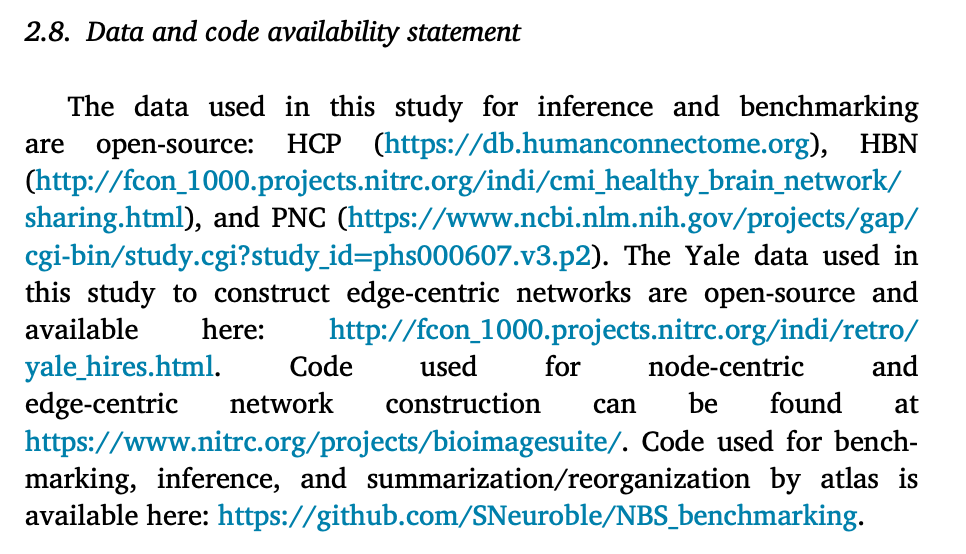

- *merged_data* contains the sentences and accompanying URLs that were classified during the manual labeling. 
- *data_clf_labeled* contains the sentences and accompanying URLs that were classified during automatic labeling. 

I will merge the *merged_dat* dataframe with the *data_clf_labeled* dataframe.

In [28]:
len(merged_data)

124

In [29]:
data_clf_encoded = data_clf_labeled.copy()

In [30]:
len(data_clf_encoded)

2732

In [31]:
# One-hot encode 'predicted_label'
one_hot_encoded = pd.get_dummies(data_clf_labeled['predicted_label'])
data_clf_encoded[['Material', 'Method', 'Supplement']] = one_hot_encoded

# Rename columns and reorder them 
data_clf_encoded = data_clf_encoded.rename(columns={'Sentences': 'sentence'})
data_clf_encoded = data_clf_encoded.drop('predicted_label', axis=1)

desired_order = ['DOI', 'URL', 'sentence', 'Material', 'Method', 'Supplement']
data_clf_encoded = data_clf_encoded[desired_order]

In [32]:
merged_data = merged_data.drop('ID', axis=1)

In [33]:
# Merge the two dataframes 
df_clf = pd.concat([merged_data, data_clf_encoded], axis=0)

In [34]:
df_clf

,DOI,URL,sentence,Method,Material,Supplement
104,10.1016/j.neuroimage.2021.118798,https://osf.io/8nbd4/,Data and code availability statement The data ...,1,1,0
142,10.1016/j.neuroimage.2021.118811,www.csie.ntu.edu.tw/∼cjlin/libsvm,We carried out MVPA using the PyMVPA software ...,1,0,0
103,10.1016/j.neuroimage.2022.118920,https://orcid.org/0000-0002-9117-4449,Tavor). 1 ORCID iD https://orcid.org/0000-0002...,0,0,0
73,10.1016/j.neuroimage.2022.118980,https://github.com/RDelahoy/DMN_eﬀective_conne...,Data and code for the eﬀective connectivity an...,1,0,0
22,10.1016/j.neuroimage.2022.118980,http://paradigmexperiments.com,The task was presented using Paradigm soft-war...,1,0,0
...,...,...,...,...,...,...
2727,10.1016/j.neuroimage.2022.119688,http://www.white.stanford.edu,Standard fMRI data analysis Preprocessing and ...,1,0,0
2728,10.1016/j.neuroimage.2022.119688,P.O.Box,While modeling receptive ﬁelds in the visual c...,0,0,1
2729,10.1016/j.neuroimage.2022.119688,2.5.3.3,"𝒍 𝝈𝒑 𝒓 𝒐 𝒑 𝒐 𝒔 𝒆 𝒅 = 𝑵 (𝒍 𝝈𝒂 𝒄 𝒄 𝒆 𝒑 𝒕 𝒆 𝒅 , 𝐰...",0,0,1
2730,10.1016/j.neuroimage.2022.118939,https://osf.io/k3xce,Data and code availability De-identiﬁed data a...,0,1,0


In [35]:
# Save the results to csv 
df_clf.to_csv('../Data/classified_data.csv', index=False)

I will now extract the datasets from the dataframe, keeping all unique urls

In [36]:
df = pd.read_csv('../Data/classified_data.csv')

In [37]:
material_urls_df = df[df['Material'] == 1]

I will remove all http://, https://, https://www., www., and htpps:// in front of the links, and remove all / and /) at the end of the links. 

In [38]:
def clean_urls(urls):
    """Remove http://, https://, https://www., www. and trailing / or /)
    """
    cleaned_urls = urls.str.replace(r'^https?://(?:www\.)?|www\.|/$|/\)$', '', regex=True, flags=re.IGNORECASE)
    cleaned_urls = cleaned_urls.str.lower()
    return cleaned_urls

In [39]:
cleaned_material_urls = clean_urls(material_urls_df['URL'])
cleaned_material_urls = sorted(cleaned_material_urls.unique())

In [40]:
len(cleaned_material_urls)

393

In [41]:
cleaned_material_urls

['2.1.1.1',
 '2.1.1.2',
 '2.1.1.3',
 '2.3.2.5',
 '2.4.3.1',
 '3.1.2.1',
 '3.2.2.1',
 '3.2.2.2',
 '3.3.1.3',
 'abcd-study.org',
 'abcdstudy.org',
 'adni.loni.usc.edu',
 'adni.loni.usc.edu/about',
 'adni.loni.usc.edu/category/aibl-study-data/the',
 'adni.loni.usc.edu/data-samples/access-data',
 'adni.loni.usc.edu/data-samples/access-data/the',
 'adni.loni.usc.edu/methods/pet-analysis-method/pet-analysis',
 'aibl.csiro.au',
 'atlas.brain-map.org',
 'atlases.ebrains.eu/viewer/-/a:juelich:iav:atlas:v1.0.0:1/t:minds:core:referencespace:v1.0',
 'ausnc.org.au/corpora/ice)',
 'balsa.wustl.edu',
 'balsa.wustl.edu/study/7',
 'balsa.wustl.edu/study/7qmqx',
 'balsa.wustl.edu/study/show/mdbp0',
 'bbci.de/competition/iv/desc_1.html',
 'bdr.birncommunity.org:8080/bdr',
 'bic.mni.mcgill.ca/servicesatlases/homepage',
 'bicr-resource.atr.jp/srpbsts',
 'bids.neuroimaging.io',
 'bigbrain.loris.ca',
 'biobank.ctsu.ox.ac.uk',
 'bitbucket.org/vtripathi/iisc/src/master/acknowledgements',
 'bmhlab.github.io/dic

<a name='validateURLs'></a>
## 3.1. Validate URLs 

I use urllib from the request module from Python to check the URLs. If a URL is not valid (i.e., it cannot be opened for some reason, e.g., by human mistake when entering the URL originally, the extraction of the URL made a mistake to it, the link might be dead, etc.), it will not be included in the final list of URLs. 

In [13]:
def check_url(url):
    """This function is primarily copied from the code provided by EuroMarkus. (2023, May 8),
    but I added put the code into both an if-else statement and a couple of try-statements.
    """
    print(url)

    # Try with 'https://'
    try:
        r = requests.get('https://' + url, stream=True, allow_redirects=True)
        if r.status_code == 200:
            content = next(r.iter_content(10))
            return True
        else:
            #print(f"HTTP Error {r.status_code} - {r.reason}")
            pass  # Continue to the next attempt
    except (requests.exceptions.RequestException, OSError) as e:
        print(f"Error for URL {url} (https://): {e}")

    # Try with 'https://' and a trailing slash
    try:
        r = requests.get('https://' + url + '/', stream=True, allow_redirects=True)
        if r.status_code == 200:
            content = next(r.iter_content(10))
            return True
        else:
            #print(f"HTTP Error {r.status_code} - {r.reason}")
            pass  # Continue to the next attempt
    except (requests.exceptions.RequestException, OSError) as e:
        print(f"Error for URL {url} (https:// with trailing /): {e}")

    # If the 'https://' version fails, try with 'https://www.'
    try:
        r = requests.get('https://www.' + url, stream=True, allow_redirects=True)
        if r.status_code == 200:
            content = next(r.iter_content(10))
            return True
        else:
            #print(f"HTTP Error {r.status_code} - {r.reason}")
            pass  # Continue to the next attempt
    except (requests.exceptions.RequestException, OSError) as e:
        print(f"Error for URL {url} (https://www.): {e}")

    # Try with 'https://www.' and a trailing slash
    try:
        r = requests.get('https://www.' + url + '/', stream=True, allow_redirects=True)
        if r.status_code == 200:
            content = next(r.iter_content(10))
            return True
        else:
            #print(f"HTTP Error {r.status_code} - {r.reason}")
            pass  # Continue to the next attempt
    except (requests.exceptions.RequestException, OSError) as e:
        print(f"Error for URL {url} (https://www. with trailing /): {e}")

    # If all attempts fail, return False
    return False

In [14]:
validation_results = pd.DataFrame({
    'URL': cleaned_material_urls,
    'IsAccessible': [check_url(url) for url in cleaned_material_urls]
})

2.1.1.1
Error for URL 2.1.1.1 (https://): HTTPSConnectionPool(host='2.1.1.1', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fb2d1aca520>: Failed to establish a new connection: [Errno 51] Network is unreachable'))
Error for URL 2.1.1.1 (https:// with trailing /): HTTPSConnectionPool(host='2.1.1.1', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fb2d12d7d00>: Failed to establish a new connection: [Errno 51] Network is unreachable'))
Error for URL 2.1.1.1 (https://www.): HTTPSConnectionPool(host='www.2.1.1.1', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fb2c3821c40>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error for URL 2.1.1.1 (https://www. with trailing /): HTTPSConnectionPool(host='www.2.1.1.1', port

In [15]:
validation_results.to_csv('../Data/URLs_validated.csv', index=False)

In [16]:
validation_results = pd.read_csv('../Data/URLs_validated.csv')

In [17]:
valid_urls = validation_results[validation_results['IsAccessible']==True]
invalid_urls = validation_results[validation_results['IsAccessible']==False]
print(f"Valid URLs: {len(valid_urls)}")
print(f"Invalid URLs: {len(invalid_urls)}")

Valid URLs: 276
Invalid URLs: 117


I manually went through each of the links where IsAaccessible==False to see if the link actually did not work and to see what parts of the link made it inaccessible if that was possible. 
I saved the results of this investigation in '../Data/URLs_validated_comments.csv'. 

In [48]:
invalid_urls_df = pd.read_csv('../Data/URLs_validated_comments.csv', delimiter=';', usecols=range(5))

In [49]:
invalid_urls_df = invalid_urls_df[invalid_urls_df['manualAccess'].notna()]

In [50]:
invalid_urls_df

,URL,IsAccessible,manualAccess,Note,Link that works
0,2.1.1.1,False,False,Not a URL,NaN
1,2.1.1.2,False,False,Not a URL,NaN
2,2.1.1.3,False,False,Not a URL,NaN
3,2.3.2.5,False,False,Not a URL,NaN
4,2.4.3.1,False,False,Not a URL,NaN
...,...,...,...,...,...
112,valdo.grand-challenge.org/description,False,False,Not found,NaN
113,"zenodo.org/record/5,088,346",False,False,NaN,NaN
114,ﬁl.ion.ucl.ac.uk,False,True,NaN,https://www.ﬁl.ion.ucl.ac.uk
115,ﬁl.ion.ucl.ac.uk/spm/data/mmfaces/,False,True,NaN,https://www.fil.ion.ucl.ac.uk/spm/data/mmfaces/


In [51]:
false_inaccessible = invalid_urls_df[invalid_urls_df['manualAccess']==True]
true_inaccessible = invalid_urls_df[invalid_urls_df['manualAccess']==False]

print(f"Of the invalid URLs, {len(true_inaccessible)} did not work when copying and pasting them into a browser manually.")
print(f"Of the invalid URLs, {len(false_inaccessible)} worked when copying and pasting them into a browser manually.")

Of the invalid URLs, 84 did not work when copying and pasting them into a browser manually.
Of the invalid URLs, 32 worked when copying and pasting them into a browser manually.


In [52]:
#invalid_urls_df[invalid_urls_df['Link that works'].notna()]
invalid_urls_df['Note'] = invalid_urls_df['Note'].fillna('')

invalidurl_worksAsIs = invalid_urls_df[(invalid_urls_df['Link that works'].notna()) & (invalid_urls_df['manualAccess'] == True)]
invalidurl_badExtraction = invalid_urls_df[(invalid_urls_df['Link that works'].notna()) & (invalid_urls_df['Note'].str.contains('Due to'))]
invalidurl_true = invalid_urls_df[(invalid_urls_df['Link that works'].isna()) & (invalid_urls_df['manualAccess'] == False) & (~(invalid_urls_df['Note'].str.contains('Due to')))]

print(f"Invalid urls that work as it should be 32: {len(invalidurl_worksAsIs)}")
print(f"Invalid urls that are invalid due to the extraction attaching a word or character that is not a part of the link: {len(invalidurl_badExtraction)}")
print(f"Invalid urls that did not work and I could not edit to make work: {len(invalidurl_true)}")

Invalid urls that work as it should be 32: 32
Invalid urls that are invalid due to the extraction attaching a word or character that is not a part of the link: 19
Invalid urls that did not work and I could not edit to make work: 61


In [53]:
invalid_urls_df[(invalid_urls_df['Link that works'].notna()) & (~(invalid_urls_df['Note'].str.contains('Due to'))) & (invalid_urls_df['manualAccess'] == False)]

,URL,IsAccessible,manualAccess,Note,Link that works
62,humanconnectome.org/data/projects/hcp_1200,False,False,Changed name?,https://www.humanconnectome.org/study/hcp-youn...


Of the URLs that the code marked as inaccessible, 
- 32 did actually work when copying and pasting them as is into a browser.
    - 30 took you to web pages that looked legit.  
    - 2 links did work, but they took you to a website that did not look safe (www.cncorpus.org and www.eegstudy.org)
- 84 did not work as they are.
    - 9 did not work due to how the URL extraction added a word of character that makes the link invalid. Specifically (everything has been converted to lowercase):
        - apply, the, and, data, supplementary, credit, 3
        - *, ), (
            - (under, (dataset, (Grootswagers
    - 61 links did not work, and I could not figure out why.
    - 1 link seems to have changed.

In addition to the 276 valid unique URLs found by the code, I found an additional 32 URLs that worked. 
When keeping only the valid unique URLs, there are a total of 308. 

I need to save the URL that works from the column 'Link that works' and save all URLs that are accessible and only save all unique URLs. 

In [54]:
# validation_results[validation_results['IsAccessible']==True]
# invalid_urls_df[invalid_urls_df['manualAccess']==True]

common_column = 'URL'

# Filter rows where 'manualAccess' is True in invalid_urls_df
valid_manual_access_urls = invalid_urls_df.loc[invalid_urls_df['manualAccess'] == True, [common_column, 'Link that works']]

# Create a dictionary mapping the original URLs to the replacement URLs
url_mapping = dict(zip(valid_manual_access_urls[common_column], valid_manual_access_urls['Link that works']))

# Iterate through validation_results and update 'URL' and 'IsAccessible'
for index, row in validation_results.iterrows():
    original_url = row[common_column]
    if original_url in url_mapping:
        # Update 'URL' and 'IsAccessible'
        validation_results.at[index, 'URL'] = url_mapping[original_url]
        validation_results.at[index, 'IsAccessible'] = True

In [55]:
# Sort and clean URLs
sorted_cleaned_urls = clean_urls(validation_results[validation_results['IsAccessible'] == True]['URL']).sort_values().unique()

urls_df = pd.DataFrame({'Material_URL': sorted_cleaned_urls})

In [56]:
urls_df

,Material_URL
0,abcdstudy.org
1,adni.loni.usc.edu
2,adni.loni.usc.edu/about
3,adni.loni.usc.edu/data-samples/access-data
4,adni.loni.usc.edu/methods/pet-analysis-method/...
...,...
300,userpage.fu-berlin.de/rmcichy/fusion_project_p...
301,wiki.humanconnectome.org/display/publicdata/ho...
302,zenodo.org
303,zenodo.org/record/5053234


I save the valid URLs. 

In [57]:
urls_df.to_csv('../Data/material_URLs.csv', index=False)

<a name='investigation'></a>
# 4. Investigation 

In [58]:
df = pd.read_csv('../Data/classified_data.csv')
urls = pd.read_csv('../Data/URLs_validated_comments.csv', delimiter=';', usecols=range(5))
urls_valid = pd.read_csv('../Data/material_URLs.csv') 

<a name='materialmethodandsupplementURLs'></a>
## 4.1. Material, method, and supplement URLs 

In [59]:
# Count the occurrences of each class in the 'predicted_label' column
method_urls = df['Method'].value_counts()
material_urls = df['Material'].value_counts()
supplement_urls = df['Supplement'].value_counts()

# Create a DataFrame to store the counts and percentages
urls_types = {
    'Class': ['Method', 'Material', 'Supplement'],
    'Count': [method_urls[1], material_urls[1], supplement_urls[1]],
    'Percentage': [round(method_urls[1] / len(df) * 100, 1), round(material_urls[1] / len(df) * 100, 1), round(supplement_urls[1] / len(df) * 100, 1)]
}

counts_df = pd.DataFrame(urls_types)
counts_df.to_csv('../Results/tables/URLsbyLabel.csv', index=False)

# Display the counts table
print("URLs by label:")
print(counts_df)

URLs by label:
        Class  Count  Percentage
0      Method   1513        53.0
1    Material    523        18.3
2  Supplement    813        28.5


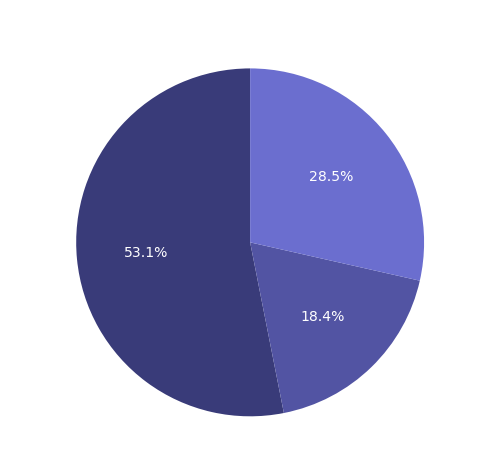

In [60]:
colors = plt.cm.tab20b.colors
plt.figure(figsize=(8, 8))
plt.pie(counts_df['Count'], labels=counts_df['Class'], autopct='%1.1f%%', startangle=90, colors=colors, textprops={'color': 'white', 'fontsize': 14})
plt.title('Distribution of URLs by Label', color='white', fontsize=16)

# Save the figure
plt.savefig('../Results/graphics/DistributionofURLs.png')

plt.show()

<a name='validandinvalidmaterialURLs'></a>
## 4.2. Valid and invalid material URLs

In [61]:
#df = pd.read_csv('../Data/classified_data.csv')
#urls = pd.read_csv('../Data/URLs_validated_comments.csv', delimiter=';', usecols=range(5))
#urls_valid = pd.read_csv('../Data/material_URLs.csv') 

In [62]:
urls

,URL,IsAccessible,manualAccess,Note,Link that works
0,2.1.1.1,False,False,Not a URL,NaN
1,2.1.1.2,False,False,Not a URL,NaN
2,2.1.1.3,False,False,Not a URL,NaN
3,2.3.2.5,False,False,Not a URL,NaN
4,2.4.3.1,False,False,Not a URL,NaN
...,...,...,...,...,...
388,uniklinikum-leipzig.de/einrichtungen/life,True,NaN,NaN,NaN
389,userpage.fu-berlin.de/rmcichy/fusion_project_p...,True,NaN,NaN,NaN
390,wiki.humanconnectome.org/display/publicdata/ho...,True,NaN,NaN,NaN
391,zenodo.org,True,NaN,NaN,NaN


In [63]:
# Running the code 
accessible_initial = len(urls[urls['IsAccessible']==True])
inaccessible_initial = len(urls[urls['IsAccessible']==False])

# Investigating the inaccessible URLs manually 
inaccessible_false = len(urls[(urls['IsAccessible']==False) & (urls['manualAccess']==True)])
inaccessible_false_badextraction = len(urls[(urls['Link that works'].notna()) & (urls['Note'].str.contains('Due to'))])
urls['Note'] = urls['Note'].fillna('')  # Fix: Remove len() from this line
inaccessible_true = len(urls[(urls['Link that works'].isna()) & (urls['manualAccess']==False) & (~urls['Note'].str.contains('Due to'))])
inaccessible_unique = len(urls[(urls['Link that works'].notna()) & (~urls['Note'].str.contains('Due to')) & (urls['manualAccess'] == False)])

# Final numbers (including non-unique) 
accessible_final = len(urls[(urls['IsAccessible']==True) | (urls['manualAccess']==True)])
inaccessible_final = len(urls[(urls['IsAccessible']==False) & (urls['manualAccess']==False)])

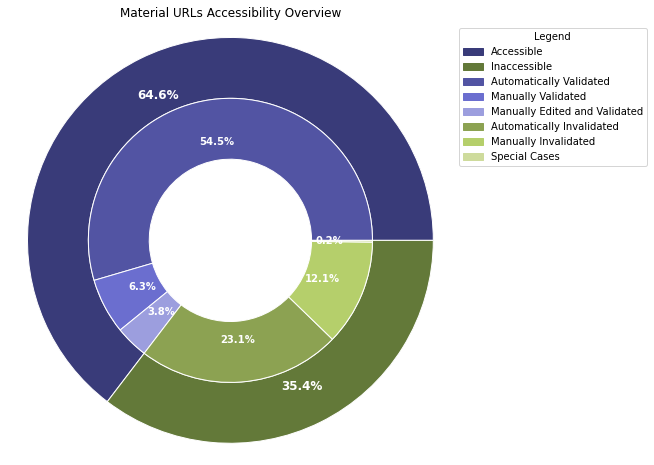

In [64]:
# Data for plotting
vals = np.array([[accessible_initial, inaccessible_false, inaccessible_false_badextraction],
                 [inaccessible_initial, inaccessible_true, inaccessible_unique]])

# Colors
cmap = plt.get_cmap("tab20b")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap([1, 2, 3, 5, 6, 7])

# Create pie chart
fig, ax = plt.subplots(figsize=(8, 8))
size = 0.3

# Outer pie
outer_pie, outer_texts, _ = ax.pie(vals.sum(axis=1), autopct='%1.1f%%', pctdistance=0.8, radius=1, colors=outer_colors,
                                   wedgeprops=dict(width=size, edgecolor='w'),
                                   textprops=dict(color="w", size=12, weight="bold"))

# Inner pie
inner_pie, inner_texts, _ = ax.pie(vals.flatten(), autopct='%1.1f%%', pctdistance=1-size, radius=1-size, colors=inner_colors,
                                   wedgeprops=dict(width=size, edgecolor='w'),
                                   textprops=dict(color="w", size=10, weight="bold"))

# Legend
legend_labels_outer = ['Accessible', 'Inaccessible']
legend_labels_inner = ['Automatically Validated', #(Accessible Initial)
                 'Manually Validated', #(Inaccessible False)
                 'Manually Edited and Validated', #(Inaccessible False Bad Extraction)
                 'Automatically Invalidated', #(Inaccessible Initial)
                 'Manually Invalidated', #(Inaccessible True)
                 'Special Cases'] #(Inaccessible Unique)

legend_colors_outer = [mpatches.Patch(color=color, label=label) for color, label in zip(outer_colors, legend_labels_outer)]
legend_colors_inner = [mpatches.Patch(color=color, label=label) for color, label in zip(inner_colors, legend_labels_inner)]

ax.legend(handles=legend_colors_outer + legend_colors_inner, title="Legend", loc="upper left", bbox_to_anchor=(1, 1))

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
ax.set_title('Material URLs Accessibility Overview')

#Save the figure
plt.savefig('../Results/graphics/MaterialURLsAccessibilityOverview.png')

plt.show()

<a name='references'></a>
# 5. References

- Beltagy, I., Lo, K., & Cohan, A. (2019). SciBERT: A Pretrained Language Model for Scientific Text (arXiv:1903.10676). arXiv. http://arxiv.org/abs/1903.10676
- Cao, H., Dodge, J., Lo, K., McFarland, D. A., & Wang, L. L. (2023). The Rise of Open Science: Tracking the Evolution and Perceived Value of Data and Methods Link-Sharing Practices. https://arxiv.org/ftp/arxiv/papers/2310/2310.03193.pdf
- caohanch. (n.d.). Paper_data_method_sharing/link_classification.ipynb at main · caohanch/paper_data_method_sharing [Jupyter Notebook]. Retrieved November 15, 2023, from https://github.com/caohanch/paper_data_method_sharing/blob/main/link_classification.ipynb
- Choudhary, R. (2021, December 29). Fine-Tuning Bert for Tweets Classification ft. Hugging Face. MLearning.Ai. https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (arXiv:1810.04805). arXiv. https://doi.org/10.48550/arXiv.1810.04805
- EuroMarkus. (2023, May 8). Answer to “Check whether url exists or not without downloading the content using python.” Stack Overflow. https://stackoverflow.com/a/76196871
- Fine-tuning BERT (and friends) for multi-label text classification. (n.d.). Retrieved November 9, 2023, from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o
- Haj-Yahia, Z., Sieg, A., & Deleris, L. A. (2019). Towards Unsupervised Text Classification Leveraging Experts and Word Embeddings. Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics, 371–379. https://doi.org/10.18653/v1/P19-1036
- Halford, M. (2020, October 3). Unsupervised text classification with word embeddings. https://maxhalford.github.io/blog/unsupervised-text-classification/
- 🤗 Hugging Face. (n.d.). Fine-tuning BERT (and friends) for multi-label text classification [Jupyter Notebook]. Retrieved November 9, 2023, from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=hiloh9eMK91o
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
- Kosar, A., Pauw, G. D., & Daelemans, W. (2022). Unsupervised Text Classification with Neural Word Embeddings. _Computational Linguistics in the Netherlands Journal_, _12_, 165–181.
- Lipovský, J. (2022). urlextract: Collects and extracts URLs from given text. (1.8.0) [Python]. https://github.com/lipoja/URLExtract
- Lhoest, Q., Villanova del Moral, A., von Platen, P., Wolf, T., Šaško, M., Jernite, Y., Thakur, A., Tunstall, L., Patil, S., Drame, M., Chaumond, J., Plu, J., Davison, J., Brandeis, S., Sanh, V., Le Scao, T., Canwen Xu, K., Patry, N., Liu, S., … Delangue, C. (2021). Datasets: A Community Library for Natural Language Processing. In Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 175–184) [Python]. Association for Computational Linguistics. https://aclanthology.org/2021.emnlp-demo.21 (Original work published 2020)
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830.
- Text classification. (n.d.). 🤗 HuggingFace - Transformers. Retrieved October 29, 2023, from https://huggingface.co/docs/transformers/tasks/sequence_classification
- Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., Cistac, P., Rault, T., Louf, R., Funtowicz, M., Davison, J., Shleifer, S., von Platen, P., Ma, C., Jernite, Y., Plu, J., Xu, C., Scao, T. L., Gugger, S., … Rush, A. M. (2020). HuggingFace’s Transformers: State-of-the-art Natural Language Processing (arXiv:1910.03771). arXiv. https://doi.org/10.48550/arXiv.1910.03771
- Zhao, H., Luo, Z., Feng, C., Zheng, A., & Liu, X. (2019). A Context-based Framework for Modeling the Role and Function of On-line Resource Citations in Scientific Literature. Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), 5205–5214. https://doi.org/10.18653/v1/D19-1524